In [19]:
%matplotlib inline
from skimage import feature
from math import sqrt
from skimage.morphology import disk, opening
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, axes, sci
from matplotlib import colors
from thunder import NMF, PCA, RegressionModel, Colorize
import numpy as np
from numpy import genfromtxt
from pyfnnd import apply_all_cells
import scipy.io
from scipy.stats import pearsonr
import math
import itertools
import glob, os
image = Colorize.image
from scipy import signal
from subprocess import Popen, PIPE
import PIL
window = signal.gaussian(5, std=1)
sns.set_context('notebook')
sns.set_style('ticks')
plt.ioff()


def Spikeinference(img,Mask):
    global MeanFluo_ROI_thund
    MeanFluo_ROI_thund=img.meanByRegions(Mask).toSeries()
    MeanFluo_ROI=img.meanByRegions(Mask).collectAsArray()
    MeanFluo_ROI=MeanFluo_ROI[1][:,0]
    MeanFluo_ROI=scipy.signal.detrend(MeanFluo_ROI)
    n_hat, C_hat, LL, theta_hat=apply_all_cells(np.transpose(MeanFluo_ROI),disp=0, n_jobs=-1,dt=0.2)
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')
    np.savetxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv',MeanFluo_ROI)
    return n_hat, C_hat, LL, theta_hat

def NMFCorr(stimparam,NMFH,data_to_analyze,p_value=0.05):
    results=[]
    lst = np.asarray(list(itertools.product([0, 1], repeat=stimparam.shape[0])))
    corrMat=np.zeros((Mask.shape[0],Mask.shape[1]),dtype=np.float32)
    for k in range(0,NMFH.shape[0]):
        result=[]
        ccr=[]
        pvalues=[]
        for j in range(1,lst.shape[0]):
            combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
            for i in np.transpose(np.nonzero(lst[j])[0]):
                combination+=stimparam[i]
            cc,pval=pearsonr(NMFH[k,:],combination[0])
            ccr.append(cc)
            pvalues.append(pval)
        result.append(ccr[np.argmin(pvalues)])
        result.append(pvalues[np.argmin(pvalues)])
        result.append(lst[np.argmin(pvalues)])
        results.append(result)
        combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
        if pvalues[np.argmin(pvalues)]<p_value:
            for i in np.transpose(np.nonzero(lst[np.argmin(pvalues)])[0]):
                combination+=stimparam[i]
            if np.any(combination):
                corrs = data_to_analyze.correlate(combination)
                corrMat = corrs.collectValuesAsArray()
                Masktemp=Mask.astype(np.float32).copy()
                for idx in xrange(0,corrMat.shape[0]):
                    Masktemp[Masktemp==idx+1]=corrMat[idx]
                fig = figure(dpi=300)
                plt.imshow(Masktemp)
                plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+' combination.png', dpi=300, bbox_inches='tight')
                scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
                plt.close("all")
    with open('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes_CorrCoef.txt', 'w') as outfile:
        i=0
        for data_slice in results:
            outfile.write ('NMF-'+str(i)+' CorrCoef : ' + np.array_str(data_slice[0]).rjust(10)+' p-value : '+ np.array_str(data_slice[1]) +' Combination of features : '+ np.array_str(data_slice[2]))
            outfile.write('\n')
            i+=1
    return

def NMF_spikes(n_hat,stimparam,numcomp=18):
    global data_to_analyze
    global model
    np.save('/mnt/downloads/'+directory+'/nhatFullData.npy',n_hat)
    data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=300)
    model = NMF(k=numcomp, maxIter=100,tol=0.0001,reconHist='final').fit(data_to_analyze)
    imgs = model.w.collectAsArray()
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')
    scores=[]
    for i in xrange(0,imgs[1].shape[1]):
        Masktemp=Mask.astype(np.float32).copy()
        for idx in xrange(0,imgs[1].shape[0]):
            Masktemp[Masktemp==idx+1]=imgs[1][idx][i]
        scores.append(Masktemp)
    for i in xrange(0,model.h.T.shape[1]):
        fig = figure(dpi=300)
        plt.subplots(1, 2, sharex=True, sharey=True)
        plt.subplot(1, 2, 1);
        plt.plot(model.h.T[:,i])
        plt.subplot(1, 2, 2);
        plt.imshow(scores[i])
        plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF-Spikes-'+str(i)+'.png', dpi=300, bbox_inches='tight')
        plt.close("all")
    NMFCorr(stimparam,np.transpose(model.h.T),data_to_analyze)
    return model



In [20]:
# def analysisNMF(data_to_analyze,dirnumber,directory,stimparam,numcomp=18,min_radius=2,max_radius=5,radius=3):
def analysisNMF(data_to_analyze,dirnumber,directory,numcomp=18,min_radius=2,max_radius=5,radius=3):
    global model
    #img_mean=img.mean()
    #selem = disk(radius)  
    fig = figure(dpi=300)
    model = NMF(k=numcomp, maxIter=100).fit(data_to_analyze)
    j=1
    imgs = model.w.pack()
    for i in xrange(0,model.h.T.shape[1],3):
        fig = figure(dpi=300)
        plt.plot(model.h.T[:,i:i+3])
        plt.savefig('/mnt/downloads/'+directory+'/'+str(dirnumber)+'-NMF-'+str(j)+'.png', dpi=300, bbox_inches='tight')
        fig = figure(dpi=300)
        maps = Colorize(cmap='indexed', colors=[ "blue","green","red"], scale=2).transform(imgs[i:i+3])
        plt.imshow(maps);
        plt.savefig('/mnt/downloads/'+directory+'/'+str(dirnumber)+'NMFb-'+str(j)+'.png', dpi=300, bbox_inches='tight')
        j+=1
        plt.close("all")
    scipy.io.savemat('/mnt/downloads/'+directory+'/'+str(dirnumber)+'-NMF.mat', mdict={'W':imgs,'H':model.h.T}, oned_as='column', do_compression='true')
    
#     lst = np.asarray(list(itertools.product([0, 1], repeat=stimparam.shape[0])))
#     NMFH=np.transpose(model.h.T)    
#     results=[]
#     corrMat=np.zeros((NMFH.shape[0],data_to_analyze.dims[0],data_to_analyze.dims[1]),dtype=np.float32)
#     for k in range(0,NMFH.shape[0]):
#         result=[]
#         ccr=[]
#         for j in range(1,lst.shape[0]):
#             combination=np.zeros((1,data_to_analyze.index.shape[0]),dtype=np.int16);
#             for i in np.transpose(np.nonzero(lst[j])[0]):
#                 combination+=stimparam[i]
#             cc=np.corrcoef(NMFH[k,:],combination)[0]
#             cc=np.delete(cc,0)
#             ccr.append(cc)
#         result.append(ccr[np.argmax(ccr)])
#         result.append(lst[np.argmax(ccr)])
#         results.append(result)
#         combination=np.zeros((1,data_to_analyze.index.shape[0]),dtype=np.int16);
#         for i in np.transpose(np.nonzero(lst[np.argmax(ccr)])[0]):
#             combination+=stimparam[i]  
#         corrs = data_to_analyze.correlate(combination)
#         corrMat[k] = corrs.pack()
#         opened = opening(imgs[k], selem)
#         blobs_log = feature.blob_log(opened, min_sigma=min_radius, max_sigma=max_radius)
# #         if not blobs_log:
# #             with open('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'NMF-'+str(k)+'segmentation.csv', 'a') as outfile:
# #                 print('No cells found')
# #         else:
#         blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
#         Mask=np.zeros((imgs[k].shape[0],imgs[k].shape[1]),dtype=np.int16)
#         i=1
#         for blob in blobs_log:
#             y, x, r = blob
#             y,x = np.ogrid[-y:imgs[k].shape[0]-y, -x:imgs[k].shape[1]-x]
#             mask = x*x + y*y <= r*r
#             Mask[mask]=i
#             i+=1
#         fig = figure(dpi=300)
#         plt.imshow(Mask)
#         plt.savefig('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'-NMF-'+str(k)+'segmentation.png', dpi=300, bbox_inches='tight')
#         propthund=img.meanByRegions(Mask).collectAsArray()
#         n_hat, C_hat, LL, theta_hat=apply_all_cells(np.transpose(propthund[1][:,0]),disp=0, n_jobs=-1)
#         scipy.io.savemat('/mnt/downloads/'+directory+'/Spikes-NMF'+str(dirnumber)+'-'+str(k)+'.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')
#         np.savetxt('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'-NMF-'+str(k)+'segmentation.csv',propthund[1][:,0])    

#     with open('/mnt/downloads/'+directory+'/NMFCorrCoef-'+str(dirnumber)+'.txt', 'a') as outfile:
#         i=1
#         for data_slice in results:
#             outfile.write ('NMF-'+str(i)+' CorrCoef' + np.array_str(data_slice[0]).rjust(10) +'Combination of features'+ np.array_str(data_slice[1]))
#             outfile.write('\n')
#             i+=1        
#     yplot=int(math.ceil(float(corrMat.shape[0])/(math.trunc(corrMat.shape[0]**(0.5)))))
#     xplot=math.trunc(corrMat.shape[0]**(0.5))
#     for j in range(0,corrMat.shape[0]):
#         plt.subplot(xplot, yplot, j+1);
#         plt.imshow(corrMat[j], cmap='RdBu_r')
#         ax = plt.gca()
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#     scipy.io.savemat('/mnt/downloads/'+directory+'/NMFcorrelation-'+str(dirnumber)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
#     plt.savefig('/mnt/downloads/'+directory+'/NMFcorrelation-'+str(dirnumber)+'.png', dpi=300, bbox_inches='tight')
    
    return

def analysisCorr( data_to_analyze,dirnumber,directory,stimparam,numcomp=18):
      
    yplot=int(math.ceil(float(stimparam.shape[0])/(math.trunc(stimparam.shape[0]**(0.5)))))
    xplot=math.trunc(stimparam.shape[0]**(0.5))  
    corrMat=np.zeros((stimparam.shape[0],data_to_analyze.dims[0],data_to_analyze.dims[1]),dtype=np.float32)
    fig = figure(dpi=300)
    plt.subplots(xplot, yplot, sharex=True, sharey=True)
    for j in range(0,stimparam.shape[0]):
        x = stimparam[j]        
        corrs = data_to_analyze.correlate(x)
        corrMat[j] = corrs.pack()
        plt.subplot(xplot, yplot, j+1);
        plt.imshow(corrMat[j], cmap='RdBu_r')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    scipy.io.savemat('/mnt/downloads/'+directory+'/correlation-'+str(dirnumber)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
    plt.savefig('/mnt/downloads/'+directory+'/correlation-'+str(dirnumber)+'.png', dpi=300, bbox_inches='tight')

    return

def analysisPCA( data_to_analyze,dirnumber,directory,stimparam,numcomp=30,min_radius=2,max_radius=5,radius=3):
    global model  
    fig = figure(dpi=300)
    model = PCA(k=numcomp).fit(data_to_analyze)
    j=1
    imgs = model.scores.pack()
    for i in xrange(0,model.comps.T.shape[1],3):
        fig = figure(dpi=300)
        plt.plot(model.comps.T[:,i:i+3])
        plt.savefig('/mnt/downloads/'+directory+'/PCA-'+str(dirnumber)+'-'+str(j)+'.png', dpi=300, bbox_inches='tight')
        fig = figure(dpi=300)
        maps = Colorize(cmap='indexed', colors=[ "blue","green","red"], scale=2).transform(imgs[i:i+3])
        plt.imshow(maps);
        plt.savefig('/mnt/downloads/'+directory+'/PCAb-'+str(dirnumber)+'-'+str(j)+'.png', dpi=300, bbox_inches='tight')
        j+=1
        plt.close("all")
    scipy.io.savemat('/mnt/downloads/'+directory+'/PCA-'+str(dirnumber)+'.mat', mdict={'W':imgs,'comps':model.comps.T}, oned_as='column', do_compression='true')
    lst = np.asarray(list(itertools.product([0, 1], repeat=stimparam.shape[0])))
    PCAcomps=np.transpose(model.comps.T)    
    results=[]
    corrMat=np.zeros((PCAcomps.shape[0],data_to_analyze.dims[0],data_to_analyze.dims[1]),dtype=np.float32)
    for k in range(0,PCAcomps.shape[0]):
        result=[]
        ccr=[]
        for j in range(1,lst.shape[0]):
            combination=np.zeros((1,data_to_analyze.index.shape[0]),dtype=np.int16);
            for i in np.transpose(np.nonzero(lst[j])[0]):
                combination+=stimparam[i]
            cc=np.corrcoef(PCAcomps[k,:],combination)[0]
            cc=np.delete(cc,0)
            ccr.append(cc)
        result.append(ccr[np.argmax(ccr)])
        result.append(lst[np.argmax(ccr)])
        results.append(result)
        combination=np.zeros((1,data_to_analyze.index.shape[0]),dtype=np.int16);
        for i in np.transpose(np.nonzero(lst[np.argmax(ccr)])[0]):
            combination+=stimparam[i]  
        corrs = data_to_analyze.correlate(combination)
        corrMat[k] = corrs.pack()
        opened = opening(imgs[k], selem)
        blobs_log = feature.blob_log(opened, min_sigma=min_radius, max_sigma=max_radius)
        if not blobs_log:
            with open('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'PCA-'+str(k)+'segmentation.csv', 'a') as outfile:
                print('No cells found') 
        else:
            blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
            Mask=np.zeros((imgs[k].shape[0],imgs[k].shape[1]),dtype=np.int16)
            i=1
            for blob in blobs_log:
                y, x, r = blob
                y,x = np.ogrid[-y:imgs[k].shape[0]-y, -x:imgs[k].shape[1]-x]
                mask = x*x + y*y <= r*r
                Mask[mask]=i
                i+=1
            fig = figure(dpi=300)
            plt.imshow(Mask)
            plt.savefig('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'-PCA-'+str(k)+'segmentation.png', dpi=300, bbox_inches='tight')
            propthund=img.meanByRegions(Mask).collectAsArray()
            n_hat, C_hat, LL, theta_hat=apply_all_cells(np.transpose(propthund[1][:,0]),disp=0, n_jobs=-1)
            scipy.io.savemat('/mnt/downloads/'+directory+'/Spikes-PCA'+str(dirnumber)+'-'+str(k)+'.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')
            np.savetxt('/mnt/downloads/'+directory+'/image-'+str(dirnumber)+'-PCA-'+str(k)+'segmentation.csv',propthund[1][:,0])   
        
    with open('/mnt/downloads/'+directory+'/PCACorrCoef-'+str(dirnumber)+'.txt', 'a') as outfile:
        i=1
        for data_slice in results:
            outfile.write ('NMF-'+str(i)+' CorrCoef' + np.array_str(data_slice[0]).rjust(10) +'Combination of features'+ np.array_str(data_slice[1]))
            outfile.write('\n')
            i+=1
      
    
    yplot=int(math.ceil(float(corrMat.shape[0])/(math.trunc(corrMat.shape[0]**(0.5)))))
    xplot=math.trunc(corrMat.shape[0]**(0.5))
    for j in range(0,corrMat.shape[0]):
        plt.subplot(xplot, yplot, j+1);
        plt.imshow(corrMat[j], cmap='RdBu_r')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    scipy.io.savemat('/mnt/downloads/'+directory+'/PCAcorrelation-'+str(dirnumber)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
    plt.savefig('/mnt/downloads/'+directory+'/PCAcorrelation-'+str(dirnumber)+'.png', dpi=300, bbox_inches='tight')
    
    return

In [21]:
s="""0.00025699
0.00850739
0.06541583
0.0784609 
0.07641301
0.06659586
0.05790289
0.04679429
0.02320798
0.01445644
0.00695772
0.00526551
0.002995  
0.0019852 
0.00128512
0.00134175
0.00040317
0
"""
GCaMP6s = np.array(s.replace("[","").replace("]","").split(),dtype=float)

aud8freq=np.zeros((8,700),dtype=np.float16);
aud8freq[0,21:21+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,407:407+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[0,612:612+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[1,47:47+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,382:382+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[1,532:532+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[2,71:71+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,356:356+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[2,507:507+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[3,96:96+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,331:331+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[3,557:557+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[4,121:121+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,308:308+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[4,487:487+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[5,146:146+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,281:281+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[5,586:586+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[6,175:175+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,256:256+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[6,461:461+GCaMP6s.shape[0]]=GCaMP6s;

aud8freq[7,200:200+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,231:231+GCaMP6s.shape[0]]=GCaMP6s;
aud8freq[7,636:636+GCaMP6s.shape[0]]=GCaMP6s;

In [ ]:
directory='GCaMP6f'
savedirectory='GCaMP6f/results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('G'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)
    n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
    model=NMF_spikes(n_hat,aud8freq)
    results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
    betas=results.select('betas').collectValuesAsArray()
    rsq=results.select('stats').collectValuesAsArray()
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
    plt.close("all") 
    results = RegressionModel.load(aud8freq, 'linear').fit(MeanFluo_ROI_thund)
    betas=results.select('betas').collectValuesAsArray()
    rsq=results.select('stats').collectValuesAsArray()
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-RAW-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')    

In [22]:
directory='GCaMP6f'
savedirectory='GCaMP6f/results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('G'):
        filelist.append(filename.rstrip('\n'))

In [24]:
filelist[70]

'GCamp6f-8tones-F1_80um.tif'

In [ ]:
for i,filename in enumerate(filelist):
    if i<71:
        pass
    else:        
        img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
        Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
        Mask=np.asarray(Mask,dtype=np.uint16)
        n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
        model=NMF_spikes(n_hat,aud8freq)
        results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
        betas=results.select('betas').collectValuesAsArray()
        rsq=results.select('stats').collectValuesAsArray()
        scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
        plt.close("all") 
        results = RegressionModel.load(aud8freq, 'linear').fit(MeanFluo_ROI_thund)
        betas=results.select('betas').collectValuesAsArray()
        rsq=results.select('stats').collectValuesAsArray()
        scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-RAW-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')    

In [6]:
directory='Fast'
savedirectory='Fast/Results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('F'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    if i<10:
        pass
    elif i==10:
        img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
        norm = img.toTimeSeries(size="32M")
        norm=norm.squelch(400).normalize(baseline='percentile').convolve(window, mode='same')
        analysisNMF(norm,filename,savedirectory)
        plt.close("all")       
    else:        
        img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
        Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
        Mask=np.asarray(Mask,dtype=np.uint16)
        n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
        model=NMF_spikes(n_hat)
        norm = img.toTimeSeries(size="32M")
        norm=norm.squelch(400).normalize(baseline='percentile').convolve(window, mode='same')
        analysisNMF(norm,filename,savedirectory)
        plt.close("all")       

In [12]:
directory='Fast'
savedirectory='Fast/Results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('F'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    if i==3:        
        img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
        Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
        Mask=np.asarray(Mask,dtype=np.uint16)
        n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
        model=NMF_spikes(n_hat)
        plt.close("all")   

In [13]:
dict_allindex=dict.fromkeys(filelist, 0)
for i,filename in enumerate(filelist):
    if i==0:
        SegmentData=np.loadtxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv')
        dict_allindex[filename]=SegmentData.shape[1]
    else:
        tempseg=np.loadtxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv')
        SegmentData=np.concatenate((SegmentData,tempseg),axis=1)
        dict_allindex[filename]=SegmentData.shape[1]
SegmentData=np.transpose(SegmentData)
np.save('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy',SegmentData)
import pickle
with open('/mnt/downloads/TonotropyResults/dict_allindex.pickle', 'wb') as handle:
      pickle.dump(dict_allindex, handle)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [11]:
directory='Fast'
savedirectory='Fast/Results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('F'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    if i==3:
        print filename

FunctionalExp2pre.tif


In [19]:
SegmentData=np.transpose(SegmentData)
np.save('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy',SegmentData)
import pickle
with open('/mnt/downloads/'+savedirectory+'/dict_allindex.pickle', 'wb') as handle:
      pickle.dump(dict_allindex, handle)

In [ ]:
directory='Fast'
savedirectory='Fast/Results'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('F'):
        filelist.append(filename.rstrip('\n'))
window = signal.gaussian(3, std=1)
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy', inputFormat='npy', minPartitions=20000)
#data_to_analyze=data_to_analyze.toTimeSeries().squelch(400).normalize(baseline='percentile').convolve(window, mode='same')
model = PCA(k=30).fit(data_to_analyze)

In [16]:
plt.ioff()
temp_idx=0
for filename in filelist:    
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.float)    
    for i in xrange(temp_idx,NMFfull['W'].shape[0]):
        Mask[Mask==i-temp_idx]=NMFfull['W'][i][28]
        if i > temp_idx+dict_allindex[filename]:
            break
    fig = figure(figsize=(10,10),dpi=300)
    plt.imshow(Mask)
    plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation-NMF_29.png', dpi=300, bbox_inches='tight')
    plt.close('all')

'FunctionalTest1post.tif'

In [3]:
tsc._sc._conf.getAll()

[(u'spark.jars',
  u'file:/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar'),
 (u'spark.driver.memory', u'5g'),
 (u'spark.app.name', u'PySparkShell'),
 (u'spark.driver.cores', u'12'),
 (u'spark.shuffle.memoryFraction', u'0.1'),
 (u'spark.driver.maxResultSize', u'20g'),
 (u'spark.local.dir', u'/mnt/temp'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.driver.extraJavaOptions', u'-Xmx15000m'),
 (u'spark.master', u'local[*]'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.executor.memory', u'40g'),
 (u'spark.driver.extraClassPath',
  u'/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar')]

In [18]:
tsc._sc._conf.set("spark.driver.maxResultSize","20g")

In [ ]:
model = PCA(k=30).fit(data_to_analyze)

In [4]:
directory='Fast'
savedirectory='Fast/Results'
os.chdir('/mnt/downloads/'+directory+'/')
SegmentData=np.load('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy')
SegmentData.shape

(870, 24109)

In [5]:
SegmentData=np.transpose(SegmentData)
n_hat, C_hat, LL, theta_hat=apply_all_cells(SegmentData,disp=0, n_jobs=-1)

In [ ]:
plt.ion()
plt.imshow(n_hat,cmap='jet')

In [12]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCells-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')

In [ ]:
np.save('/mnt/downloads/'+directory+'/nhatFullData.npy',n_hat)
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=20000)
model = NMF(k=30, maxIter=100,tol=0.0001,reconHist='final').fit(data_to_analyze)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCells-NMF_Spikes.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')

In [14]:
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=20000)

In [16]:
model = PCA(k=30).fit(data_to_analyze)
imgs = model.scores.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCells-NMF_Spikes.mat', mdict={'scores':imgs,'comps':model.comps.T}, oned_as='column', do_compression='true')

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 205.0 failed 1 times, most recent failure: Lost task 1.0 in stage 205.0 (TID 4040004, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/series.py", line 89, in <lambda>
    d = self.rdd.keys().mapPartitions(lambda i: [Dimensions(i, n)]).reduce(lambda x, y: x.mergeDims(y))
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 14, in __init__
    self.merge(v)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 17, in merge
    self.min = tuple(map(min, self.min, value))
TypeError: argument 3 to map() must support iteration

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1919)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor38.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2355, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/series.py", line 89, in <lambda>
    d = self.rdd.keys().mapPartitions(lambda i: [Dimensions(i, n)]).reduce(lambda x, y: x.mergeDims(y))
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 14, in __init__
    self.merge(v)
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/rdds/keys.py", line 17, in merge
    self.min = tuple(map(min, self.min, value))
TypeError: argument 3 to map() must support iteration

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [21]:
imgs = model.scores.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCells-NMF_Spikes.mat', mdict={'scores':imgs[1],'comps':model.comps.T}, oned_as='column', do_compression='true')

In [22]:
SegmentData=np.load('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy')
SegmentData.shape

(870, 24109)

In [23]:
SegmentData=np.transpose(SegmentData)

In [5]:
directory='Fast'
savedirectory='Fast/Results'
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/SegmentFullData.npy', inputFormat='npy', minPartitions=20000)
model = PCA(k=30).fit(data_to_analyze)
imgs = model.scores.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCells-PCA_RAW.mat', mdict={'scores':imgs[1],'comps':model.comps.T}, oned_as='column', do_compression='true')

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:703)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:702)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:702)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:1514)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:1438)
	at org.apache.spark.SparkContext$$anonfun$stop$7.apply$mcV$sp(SparkContext.scala:1724)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1185)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1723)
	at org.apache.spark.SparkContext$$anonfun$3.apply$mcV$sp(SparkContext.scala:587)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:264)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:234)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:234)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:234)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1699)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:234)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:234)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:234)
	at scala.util.Try$.apply(Try.scala:161)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:234)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:216)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1919)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


In [3]:
import pyfnnd

In [12]:
directory='Test'
savedirectory='Test/Results'
SegmentData=np.load('/mnt/downloads/'+directory+'/SegmentDataFull.npy')

In [5]:
SegmentData=np.transpose(SegmentData)

In [14]:
Mean=np.mean(SegmentData,axis=0)
Mean.shape

(700,)

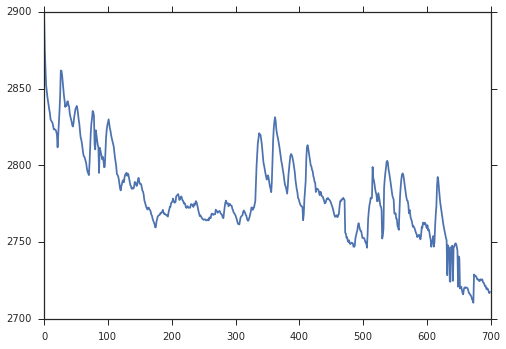

In [38]:
plt.ion()
plt.plot(F[0,:])

In [13]:
SegmentData.shape

(355590, 700)

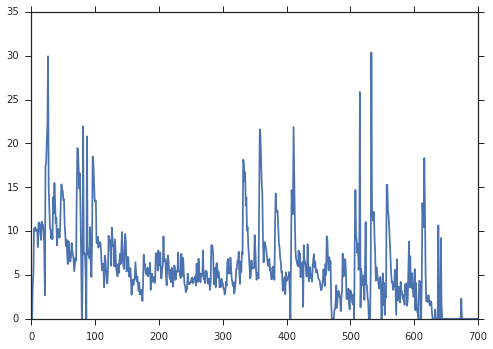

In [44]:
n_best, c_best, LL, theta_best = pyfnnd.deconvolve(F, dt=0.2, rate=1, tau=1.7, spikes_tol=1E-6, params_tol=1E-6)
plt.ion()
plt.plot(n_best)

(<matplotlib.figure.Figure at 0x7eff3fa1ff90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff3f7f6210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff3f76b190>], dtype=object))

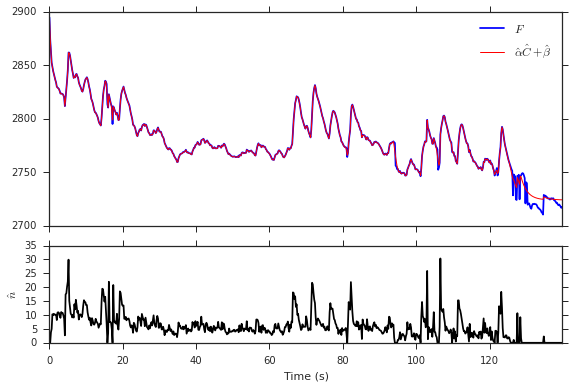

In [45]:
pyfnnd.plotting.plot_fit(F,n_best, c_best,theta_best,0.2)

(<matplotlib.figure.Figure at 0x7eff3f807f50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff3fa53850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff3e73aad0>], dtype=object))

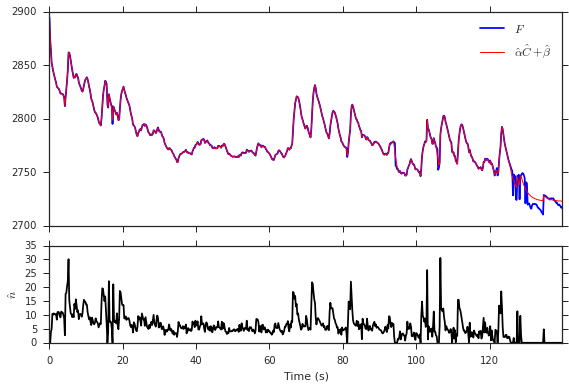

In [61]:
n_best, c_best, LL, theta_best = pyfnnd.deconvolve(F, dt=0.2, learn_theta=(1, 1, 1, 0, 0), rate=1, tau=1.7,norm_alpha=1, spikes_tol=1E-6, params_tol=1E-6)
pyfnnd.plotting.plot_fit(F,n_best, c_best,theta_best,0.2)

In [43]:
theta_best

(22.402809809330812,
 array([ 1.]),
 array([ 2724.11401656]),
 0.5,
 0.98019867330675525)

In [36]:
F=np.zeros((1,700))
F=F+Mean
F.shape

(1, 700)

In [62]:
theta_best

(24.625444978312895,
 array([ 1.]),
 array([ 2722.71392266]),
 1,
 0.88900976540277565)

In [63]:
SegmentData.shape

(355590, 700)

In [74]:
ZS.shape

(355590, 700)

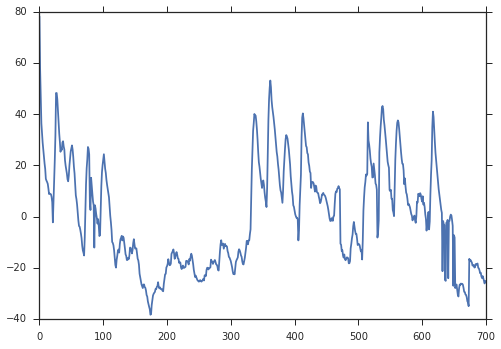

In [66]:
plt.plot(G[0,:])

(<matplotlib.figure.Figure at 0x7eff3d7bde10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff3d439490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff3d3e5d90>], dtype=object))

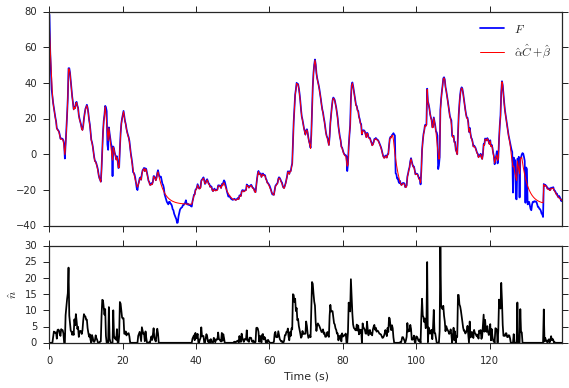

In [70]:
n_best, c_best, LL, theta_best = pyfnnd.deconvolve(G, dt=0.2, learn_theta=(1, 1, 1, 0, 0), rate=1, tau=1.7,spikes_tol=1E-6, params_tol=1E-6)
pyfnnd.plotting.plot_fit(G,n_best, c_best,theta_best,0.2)

In [68]:
theta_best

(23.298378043699756,
 array([ 1.]),
 array([-27.99837372]),
 1,
 0.88900976540277565)

In [71]:
SegmentData=scipy.signal.detrend(SegmentData)

In [73]:
ZS=scipy.stats.mstats.zscore(SegmentData,axis =1)
ZS.shape

TypeError: 'tuple' object is not callable

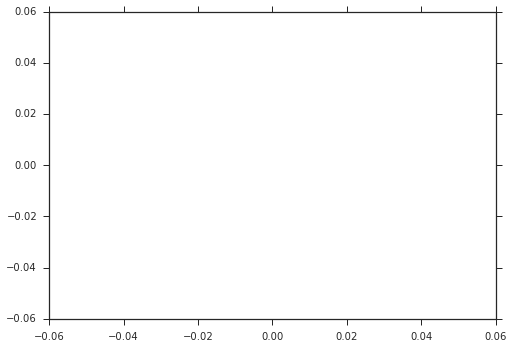

In [75]:
MeanZS=np.mean(ZS,axis=0)
plt.plot(MeanZS)

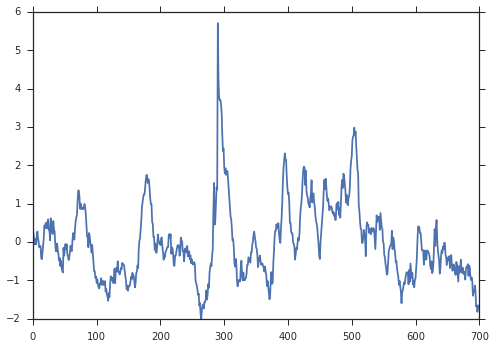

In [89]:
plt.plot(ZS[1000,:])

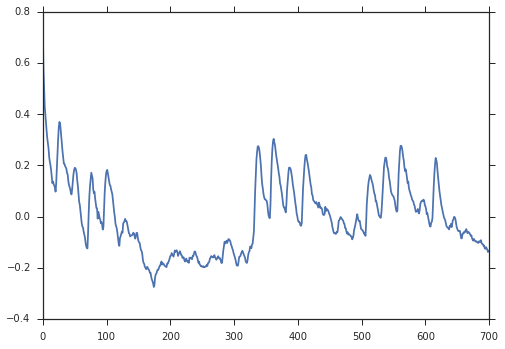

In [96]:
plt.plot(meanZS)

In [83]:
test=ZS(ZS.max(axis=1))

TypeError: 'numpy.ndarray' object is not callable

In [85]:
test=ZS.max(axis=1)
test.shape

(355590,)

In [92]:
ZSfilt=ZS[idx,:]

In [114]:
ZSfilt.shape

(309938, 700)

In [113]:
scipy.io.savemat('/mnt/downloads/Test/results/index_ZS.mat',mdict={'Index':idx}, oned_as='column', do_compression='true')

In [97]:
meanZS_F=np.zeros((1,700))
meanZS_F=meanZS_F+meanZS
meanZS_F.shape

(1, 700)

(<matplotlib.figure.Figure at 0x7eff3aed35d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff3a7f6910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff3a6f0410>], dtype=object))

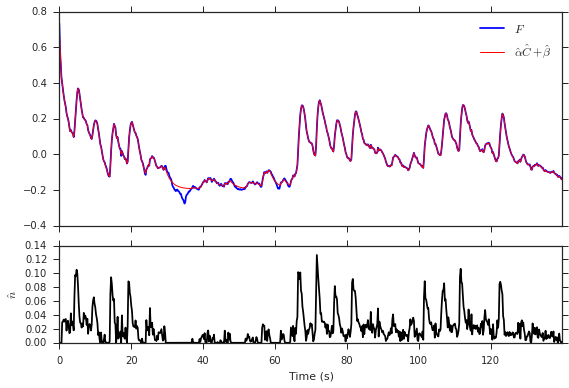

In [108]:
fig = figure(dpi=300,figsize=(10,10))
n_best, c_best, LL, theta_best = pyfnnd.deconvolve(meanZS_F,dt=0.2,spikes_tol=1E-6, tau=1.7, params_tol=1E-6)
pyfnnd.plotting.plot_fit(meanZS_F,n_best, c_best,theta_best,0.2)

In [100]:
pyfnnd.plotting.plot_fit(meanZS_F,n_best, c_best,theta_best)

TypeError: plot_fit() takes exactly 5 arguments (4 given)

In [121]:
n_hat, C_hat, LL, theta_hat=apply_all_cells(ZSfilt,disp=0, n_jobs=11,dt=0.2)
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/proper-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')

IOError: [Errno 2] No such file or directory: '/mnt/downloads/Test/Results/proper-ROI_SpikePred.mat'

In [122]:
n_hat.shape

(309938, 700)

In [124]:
scipy.io.savemat('/mnt/downloads/Test/proper-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')